<a href="https://colab.research.google.com/github/GianmarcoLattaruolo/Stat_Method_4HDD/blob/main/Stats_merged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project : Statistical Methods for High Dimensional Data
# News classification
### Add your names

In this project we will test several models seen during the lectures to address a text classification problem. 
Specifically we will work on a dataset of 100k news titles classified in 8 different classes.

In [ ]:
install.packages('quanteda')
install.packages('quanteda.textplots')
install.packages('glmnet')
install.packages('doMC')
install.packages('sparseSVM')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ISOcodes’, ‘fastmatch’, ‘Rcpp’, ‘RcppParallel’, ‘SnowballC’, ‘stopwords’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘extrafontdb’, ‘Rttf2pt1’, ‘statnet.common’, ‘extrafont’, ‘ggrepel’, ‘sna’, ‘igraph’, ‘network’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library('parallel')
library('quanteda')
library('quanteda.textplots')
library('glmnet')
library('doMC')
library('sparseSVM')

id <- "1t_bpJX7PC0dqZ5pEmaxM8wmDJteYmOXB" # google file ID
news <- read.csv(sprintf("https://docs.google.com/uc?id=%s&export=download", id), row.names=NULL, sep = ';')
nrow(news)

Package version: 3.2.4
Unicode version: 10.0
ICU version: 60.2

Parallel computing: 2 of 2 threads used.

See https://quanteda.io for tutorials and examples.

Loading required package: Matrix

Loaded glmnet 4.1-6

Loading required package: foreach

Loading required package: iterators



[1] 108774

In [ ]:
set.seed(123)
size <- floor(0.8 * nrow(news))
mask <- sample(seq_len(nrow(news)), size=size)
data_train <- news[mask, ]
data_test <- news[-mask, ]

In [ ]:
prepare_dfm <- function(src, fit=TRUE, words_to_include=NULL){
  # does the preprocessing steps, returns a dfm
  # fit=TRUE trims based on frequency
  # fit=FALSE makes the features=words_to_include
  tokens <- quanteda::tokens(src,remove_punct = TRUE,
            remove_symbols = TRUE,
            remove_numbers = TRUE,
            remove_url = TRUE,)
  dfm <- quanteda::dfm(tokens)
  dfm <- quanteda::dfm_remove(dfm,stopwords('english'))
  dfm <- quanteda::dfm_wordstem(dfm)
  if(fit) {
    dfm <- quanteda::dfm_trim(dfm, min_docfreq = 8)
  } else {
    dfm <- quanteda::dfm_match(dfm, words_to_include)
  }
  return(dfm)
}

In [ ]:
dfm_train <- prepare_dfm(data_train$title)
dfm_test <- prepare_dfm(data_test$title, fit=FALSE, words_to_include = featnames(dfm_train))

In [ ]:
# tf-idf, calculated on train
# weight the matrices with tf
x_train <- quanteda::dfm_weight(dfm_train, scheme='prop')
x_test <- quanteda::dfm_weight(dfm_test, scheme='prop')
# calculate idfs on train
idfs <- docfreq(dfm_train, scheme='inverse')
# weight by idfs
x_train <- quanteda::dfm_weight(x_train, weights=idfs, force=TRUE)
x_test <- quanteda::dfm_weight(x_test, weights=idfs, force=TRUE)

y_train <- as.factor(news$topic)[mask]
y_test <- as.factor(news$topic)[-mask]

## Data Exploration




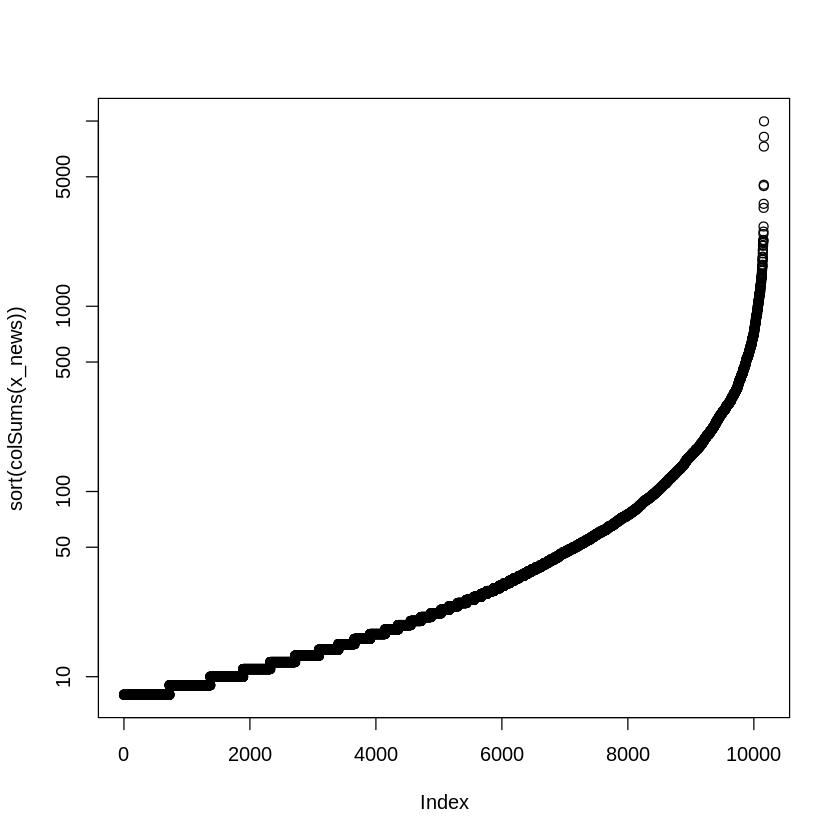

In [ ]:
dfm_news <- prepare_dfm(news$title)
x_news <- quanteda::dfm_weight(dfm_news, scheme='boolean')
y_news <- as.factor(news$topic)
plot(sort(colSums(x_news)),log='y')

In [ ]:
if(!require("quanteda.textplots")){
  install.packages('quanteda.textplots')
  library('quanteda.textplots')
}

Loading required package: quanteda.textplots

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘quanteda.textplots’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘extrafontdb’, ‘Rttf2pt1’, ‘statnet.common’, ‘extrafont’, ‘ggrepel’, ‘sna’, ‘igraph’, ‘network’




Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


[1] "TECHNOLOGY"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


[1] "BUSINESS"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


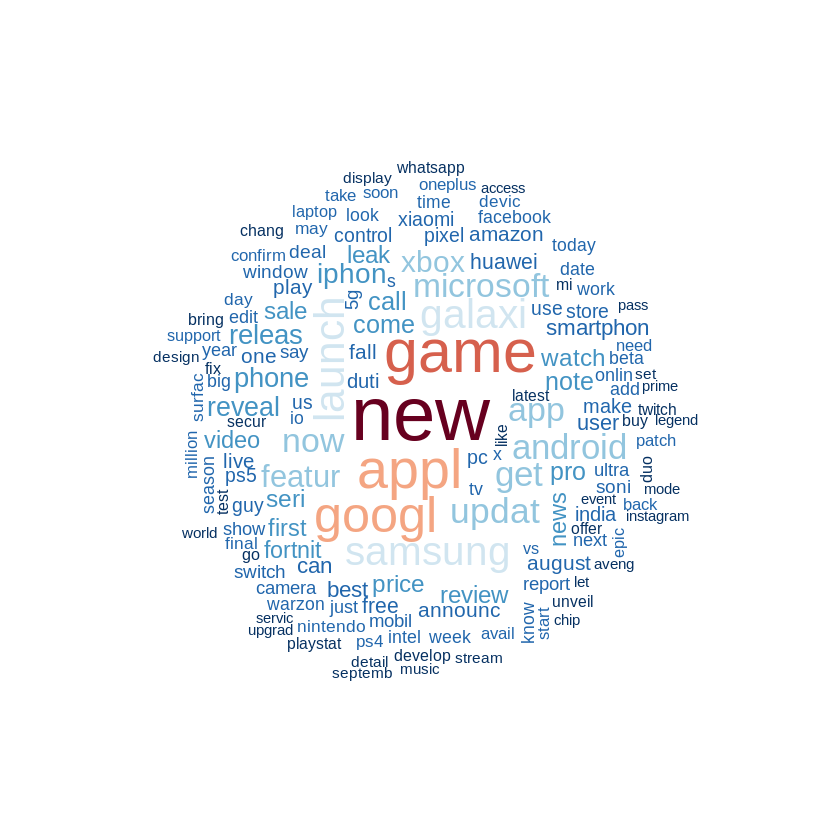

[1] "WORLD"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


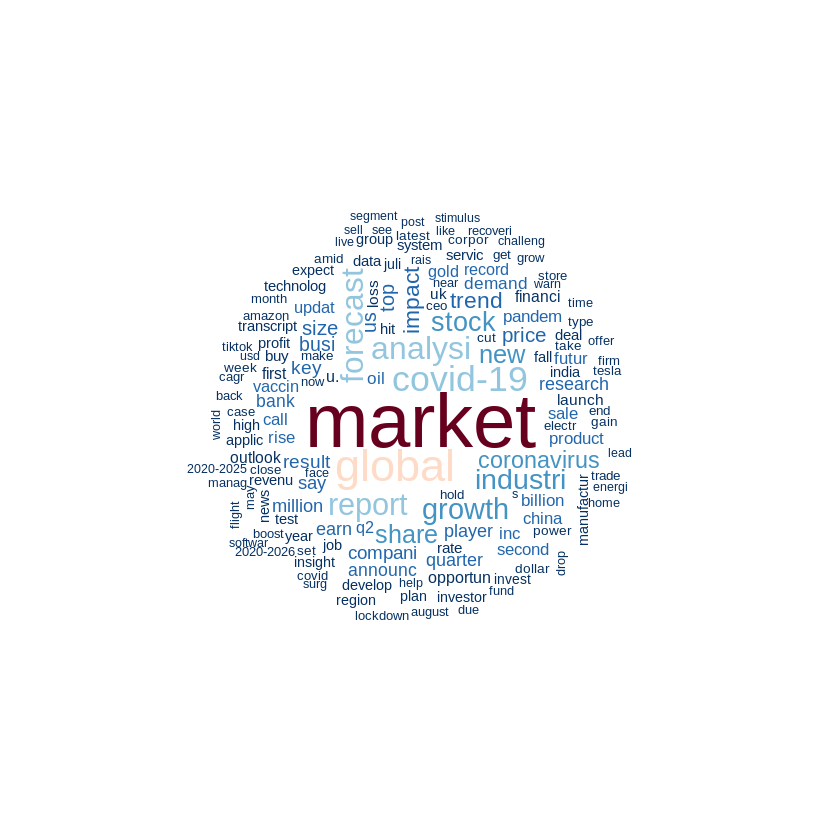

[1] "SCIENCE"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


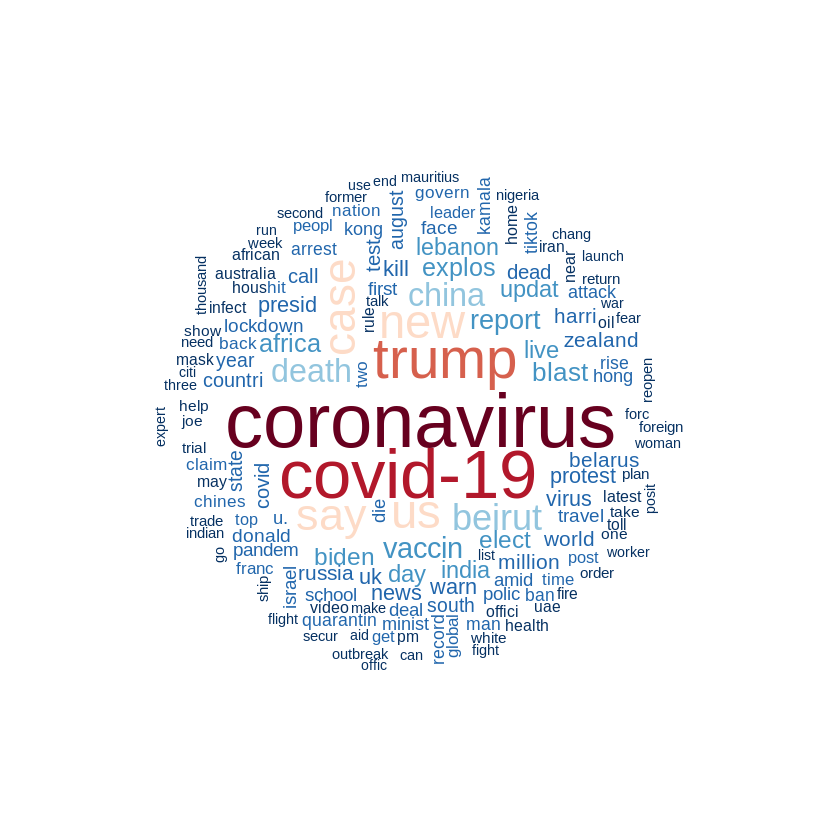

[1] "HEALTH"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


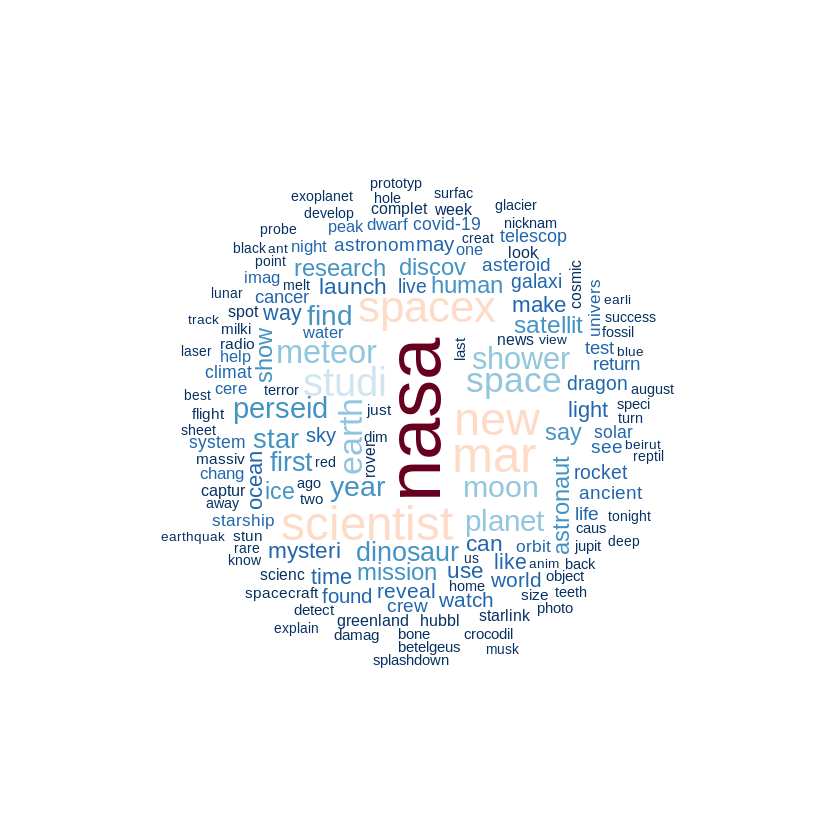

[1] "ENTERTAINMENT"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


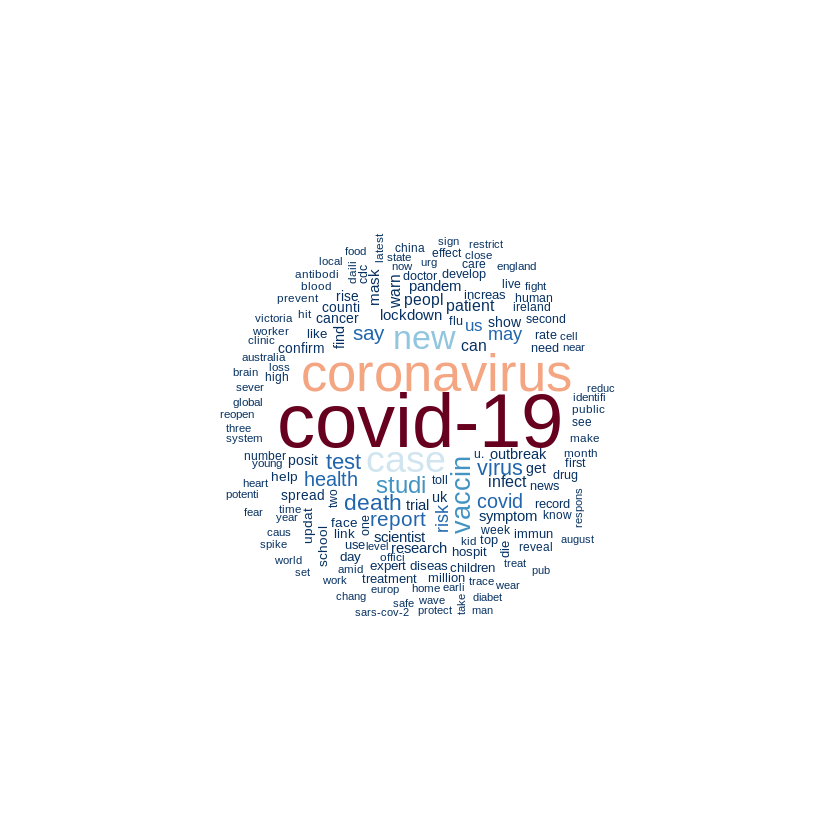

[1] "SPORTS"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


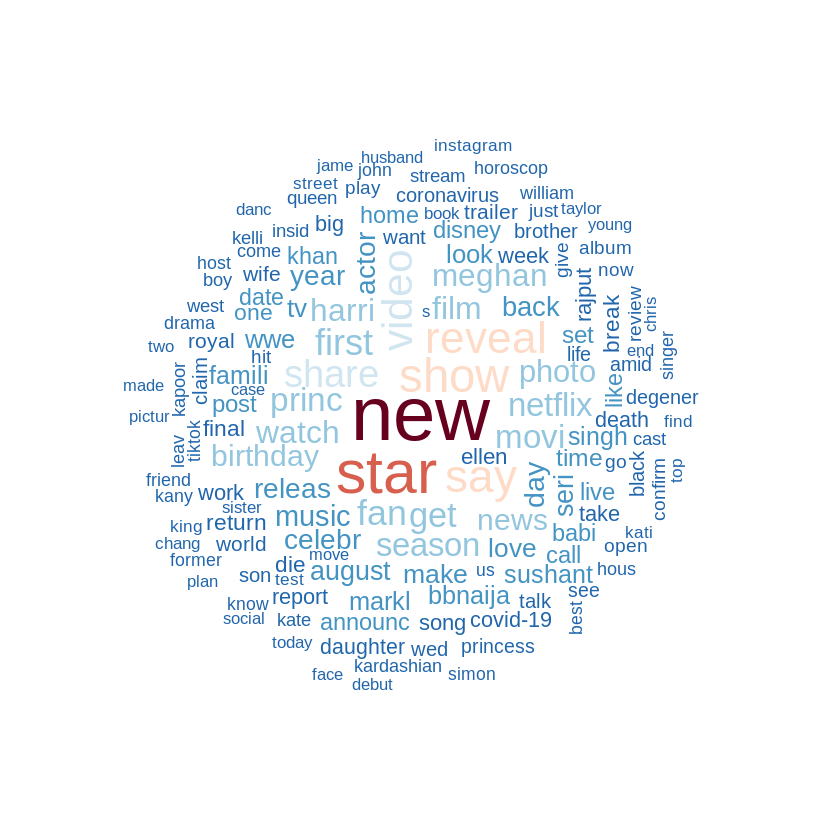

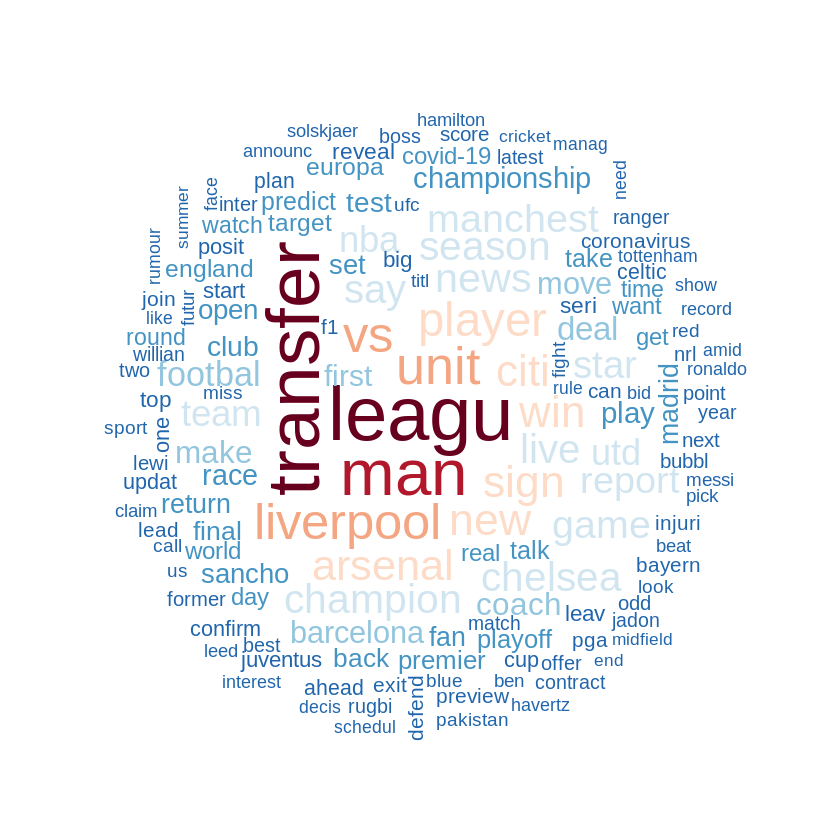

[1] "NATION"


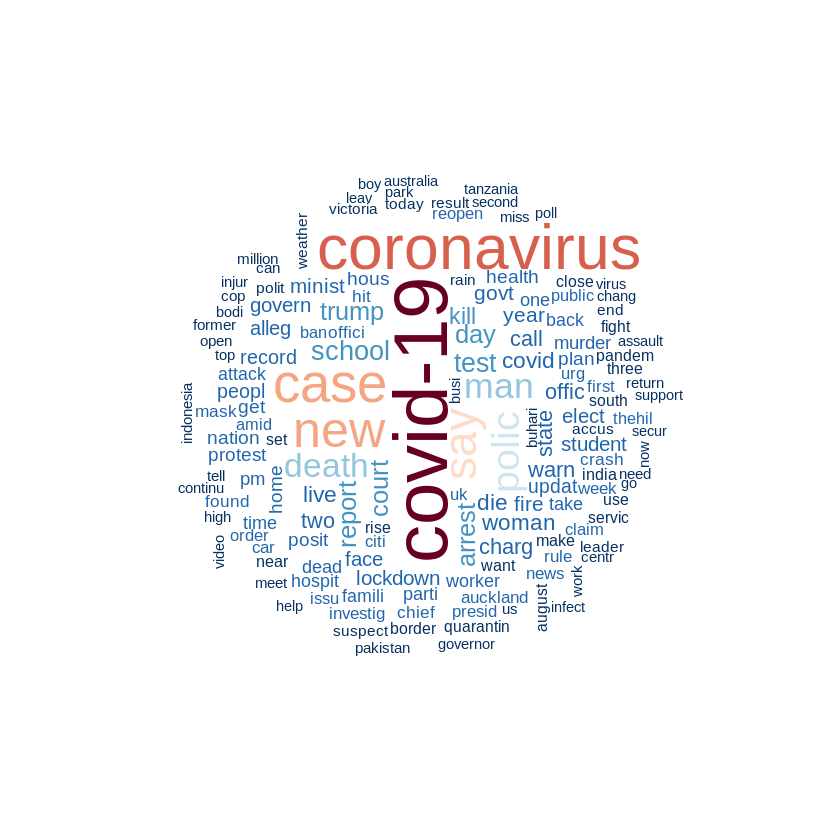

In [ ]:
par(mfrow = c(1,1))
docvars(x_news, 'topic') <- news$topic

for (i in c('TECHNOLOGY', 'BUSINESS', 'WORLD' ,'SCIENCE' ,'HEALTH', 'ENTERTAINMENT' ,'SPORTS', 'NATION')){
  topic.todisplay <- i
  textplot_wordcloud(
    dfm_subset(x_news, topic==topic.todisplay),
    color=rev(RColorBrewer::brewer.pal(10, "RdBu")),
    max_words = 150
  )
  print(i)
}

# Building Models

In [ ]:
if (!require('glmnet')){
  install.packages('glmnet')
  library('glmnet')
}

Loading required package: glmnet

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘glmnet’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Loading required package: Matrix

Loaded glmnet 4.1-6



In [ ]:
if (!require('doMC')){
  install.packages('doMC')
  library('doMC')
}

Loading required package: doMC

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘doMC’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



## Multinomial Logistic Regression, cross validation for alpha and lambda

In [ ]:
registerDoMC()

foldid <- sample(1:3, size = length(y_train), replace = TRUE)
cv1 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 1)
cv.5 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0.5)
cv0 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0)
cv.8 <- cv.glmnet(x_train, y_train, family="multinomial",type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0.8)
cv.2 <- cv.glmnet(x_train, y_train, family="multinomial",type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0.2)

In [ ]:
c(min(cv0$cvm), min(cv.2$cvm), min(cv.5$cvm), min(cv.8$cvm), min(cv1$cvm))

[1] 0.2163780 0.2207679 0.2215263 0.2215723 0.2217332

We can see that the best result is achieved using ridge regression. Let's plot the results for the alpha - 1, 0.5 and 0

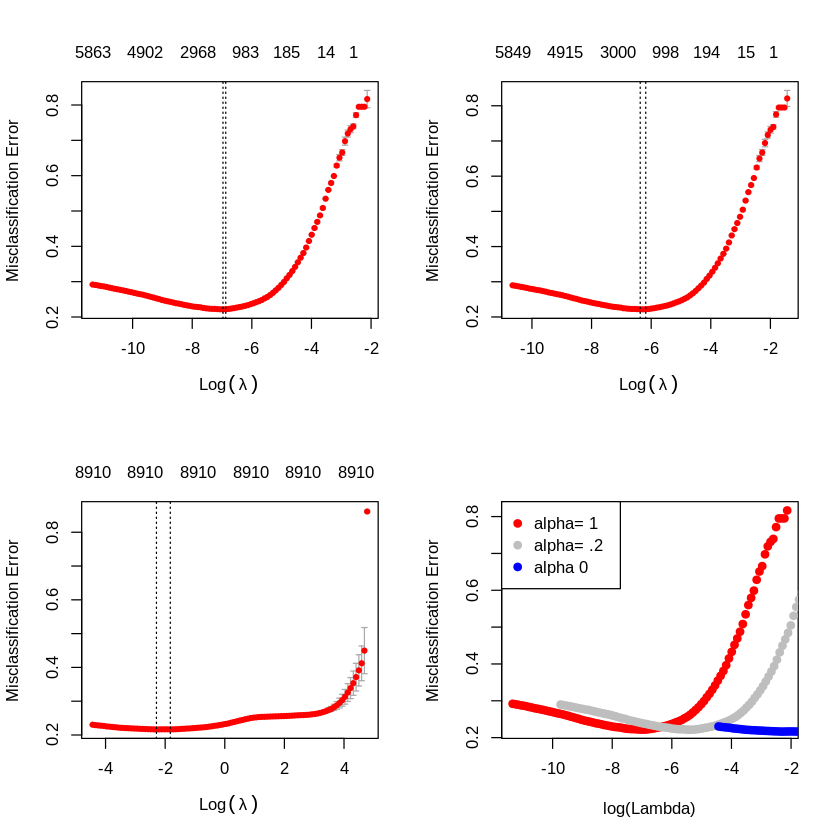

In [ ]:
par(mfrow = c(2,2))
plot(cv1); plot(cv.5); plot(cv0);
plot(log(cv1$lambda) , cv1$cvm , pch = 19, col = "red",
xlab = "log(Lambda)", ylab = cv1$name)
points(log(cv.2$lambda), cv.5$cvm, pch = 19, col = "grey")
points(log(cv0$lambda) , cv0$cvm , pch = 19, col = "blue")
legend("topleft", legend = c("alpha= 1", "alpha= .2", "alpha 0"),pch = 19, col = c("red","grey","blue"))

Let's make a prediction using the model with alpha = 0

In [ ]:
pred.train <- predict(cv0, newx = x_train, type="class")
pred.test <- predict(cv0, newx=x_test, type="class")
print(mean(y_train==pred.train))
print(mean(y_test==pred.test))

[1] 0.8414484
[1] 0.791772


The best model gives the accuracy on the test set 79.2%

Plot the word cloud based on the absolute value of the coefficients 

In [ ]:
# plot worldcloud with coefficients
plot_coefs <- function(coefs, features) {
	dfm.coefs <- quanteda::dfm(tokens(''))
	dfm.coefs <- dfm_match(dfm.coefs, features) + 1
	abs.coefs <- abs(as.vector(coefs)[-1])
	names(abs.coefs) <- features
	dfm.coefs <- dfm_weight(dfm.coefs, weights=abs.coefs,force=TRUE)
	textplot_wordcloud(
		dfm.coefs,
		color=rev(RColorBrewer::brewer.pal(10, "RdBu")),
    max_words = 100)
}

Warning message in wordcloud(x, min_size, max_size, min_count, max_words, color, :
“nationalist could not be fit on page. It will not be plotted.”
Warning message in wordcloud(x, min_size, max_size, min_count, max_words, color, :
“epilepsi could not be fit on page. It will not be plotted.”
Warning message in wordcloud(x, min_size, max_size, min_count, max_words, color, :
“oregon could not be fit on page. It will not be plotted.”
Warning message in wordcloud(x, min_size, max_size, min_count, max_words, color, :
“shepparton could not be fit on page. It will not be plotted.”
Warning message in wordcloud(x, min_size, max_size, min_count, max_words, color, :
“sclerosi could not be fit on page. It will not be plotted.”


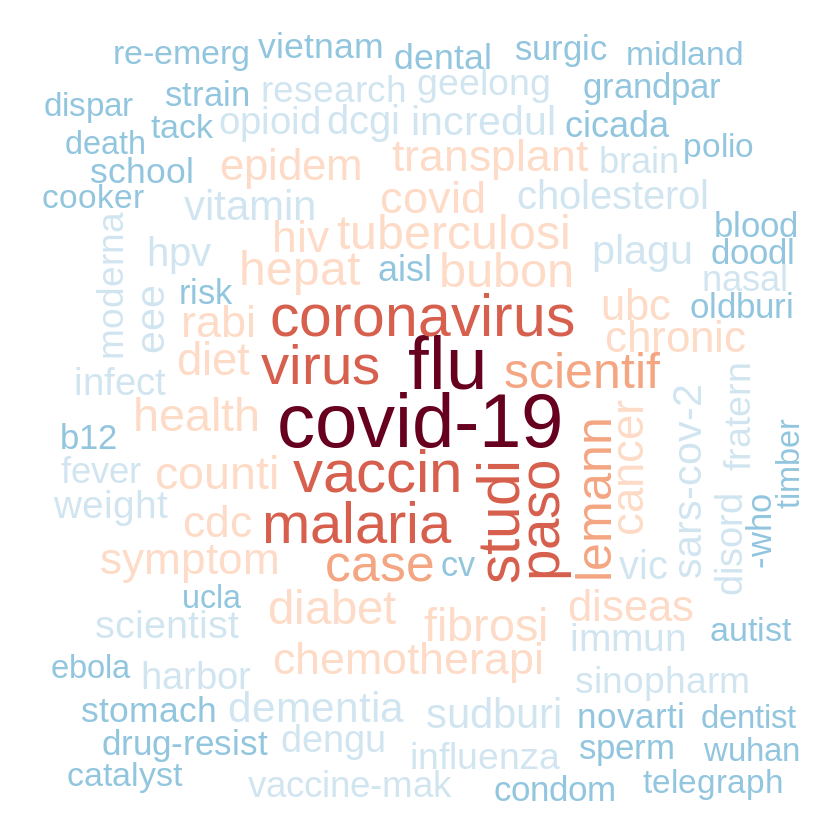

In [ ]:
plot_coefs(coef(cv1)$HEALTH, featnames(x_train))

## Sparse SVM

Now we try to implement a sparse SVM with lasso penalty. We know by the theory that the results should be similar to logistic lasso.

Unforntunately for this model the RAM size is a severe bottle neck and thus we can use only a fraction $\rho$ of the original dataset as training set.
Moreover the package sparseSVM can implement only binary classification so we need to implement a one-vs-rest approach in a for loop.

First of all we implement a cross validation for few categories to have an idea of the range values for lambda. Then, with these lambdas we implement the loop.

In [ ]:
#dataset reduction
set.seed(123)
rho = 0.1
size <- floor(rho * nrow(x_train))
mask <- sample(seq_len(nrow(x_train)), size=size)
x_train_small <- x_train[mask, ]
y_train_svm <- y_train[mask]

#for parallel computing we need a matrix
x_train_svm <- as.matrix(x_train_small)


Start parallel computing for cross-validation...

[1] 0.01570966

Start parallel computing for cross-validation...

[1] 0.0247093

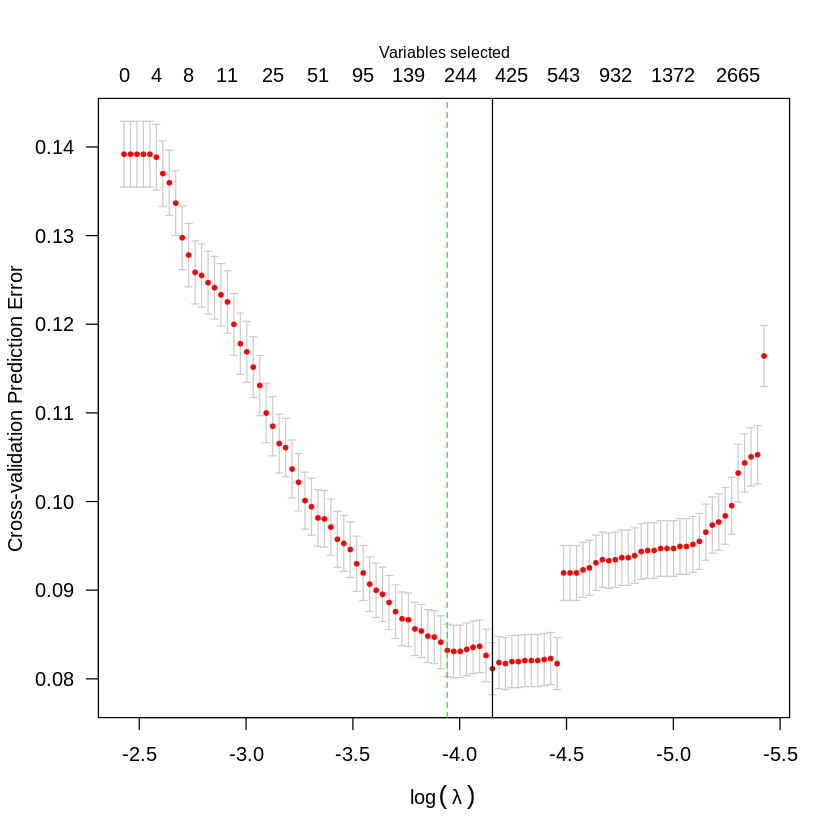

Start parallel computing for cross-validation...

[1] 0.02635349

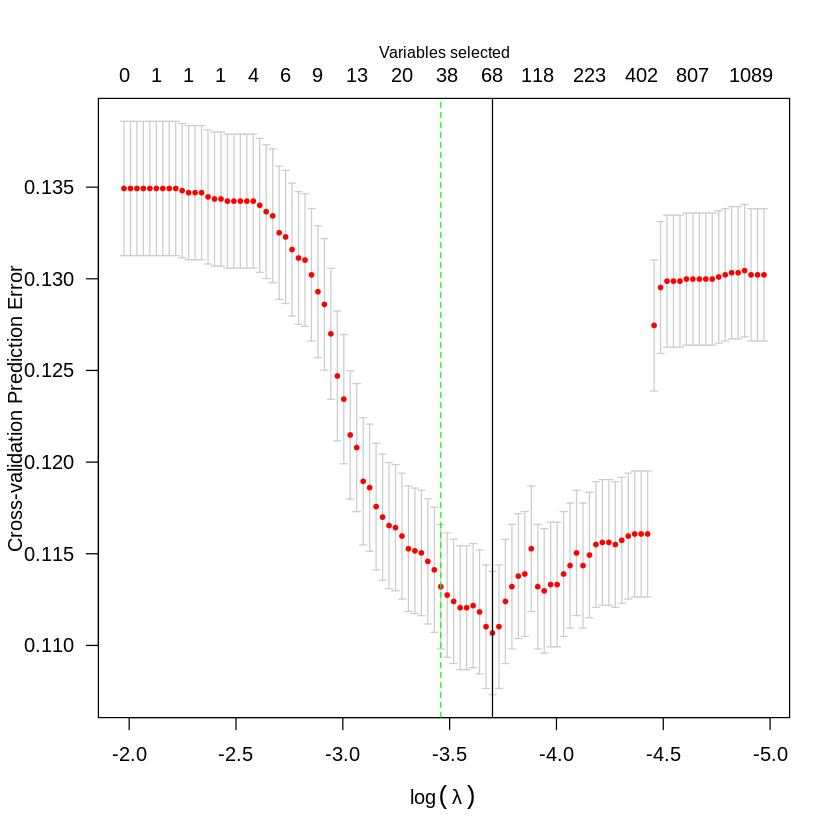

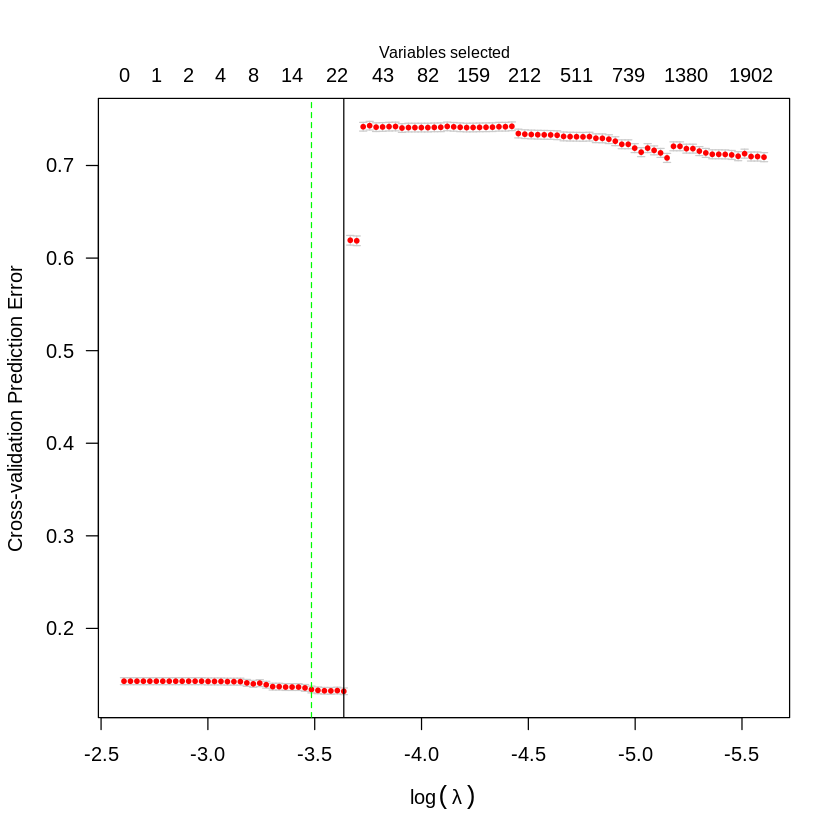

In [ ]:
tec <- c(y_train_svm=='TECHNOLOGY')+0

cv.svm <- cv.sparseSVM(x_train_svm, tec, nfolds = 6 , ncores = 2)
cv.svm$lambda.min
plot(cv.svm)
rule1se <- max(cv.svm$lambda[cv.svm$cve <= min(cv.svm$cve)+cv.svm$cvse[cv.svm$min]])
abline(v=log(cv.svm$lambda.min))
abline(v=log(rule1se),col="green", lty=2)

busi <- c(y_train_svm=='BUSINESS')+0

cv.svm <- cv.sparseSVM(x_train_svm, busi, nfolds = 6 , ncores = 2)
cv.svm$lambda.min
plot(cv.svm)
rule1se <- max(cv.svm$lambda[cv.svm$cve <= min(cv.svm$cve)+cv.svm$cvse[cv.svm$min]])
abline(v=log(cv.svm$lambda.min))
abline(v=log(rule1se),col="green", lty=2)

# with one tenth of the original training set this cell requires 6 minutes

From now on we set as grid of values for lambda 10 values. In the following for loop the predicted values are independently computed for each class. 

In [ ]:
x_test_svm <- as.matrix(x_test)

topics <- c('TECHNOLOGY', 'BUSINESS', 'WORLD' ,'SCIENCE' ,'HEALTH', 'ENTERTAINMENT' ,'SPORTS', 'NATION')
primes <- c(3,5,7,11,13,17,19,23)
i=1
acc <- c()
final_pred <- rep(1, length(y_test))
for (topic in topics){
  mask <- c(y_train_svm==topic)+0
  lasso.svm <- sparseSVM(x_train_svm, mask,nlambda = 10)
  pred_train <- predict(lasso.svm, x_train_svm, lambda=lasso.svm$lambda, type='class')
  err <- as.matrix(colSums(abs(pred_train-mask)))
  lm_index <- which.min(err)
  mask_test <- c(y_test==topic)+0
  pred_test <- predict(lasso.svm, x_test_svm, lambda=lasso.svm$lambda[lm_index], type='class')
  final_pred <- final_pred * (pred_test * (primes[i]-1)+1)
  acc[i] <- 1 - sum(abs(pred_test-mask_test))/length(y_test)
  i <- i+1
}
 
acc  #the accuracies in a one-vs-rest approach for each class seems not bad, but clearly these are unbalanced results...
#a classifier which says always "rest" is right 7/8 times (0.875) and there are values even less than this...very bad


#this cell requires 4 minutes

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


[1] 0.9111469 0.8746035 0.8858194 0.9698000 0.8652724 0.8996553 0.9190991
[8] 0.8613652

In [ ]:
final_pred[30:40]
length(final_pred)
sum(final_pred==1) #half of the test does not belong to any class according to these classifiers 
sum(final_pred == 15 | final_pred==21 | final_pred>23) # 1641 have more than 1 class

[1] 55  3  1 95  3 11 57 57  1  3  3

[1] 21755

[1] 10011

[1] 1641

Let's have a look to the plot of the last sparse SVM fit:

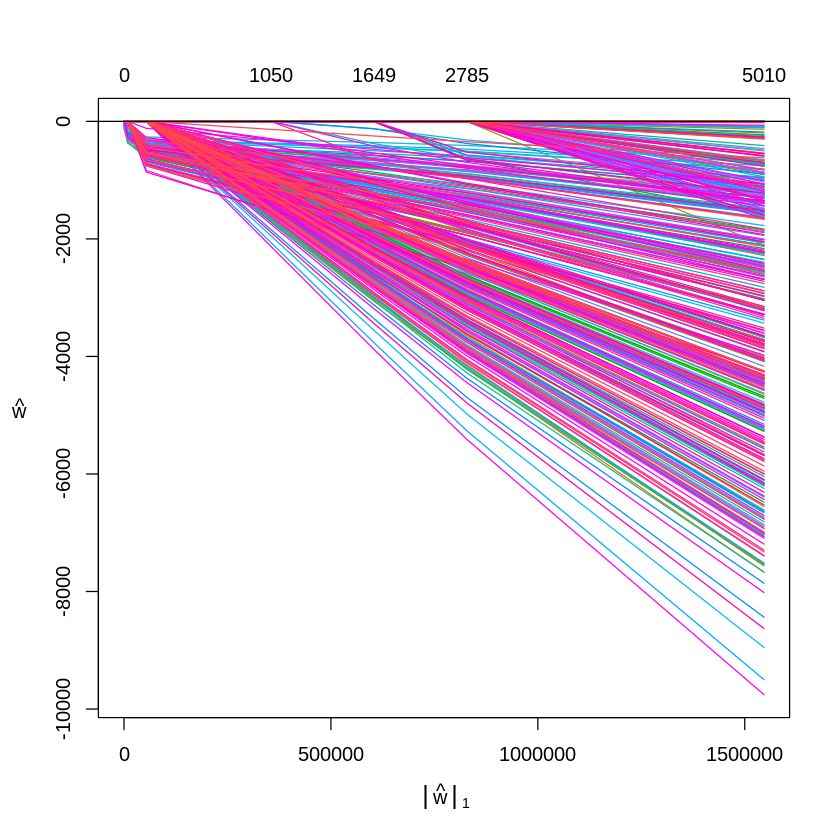

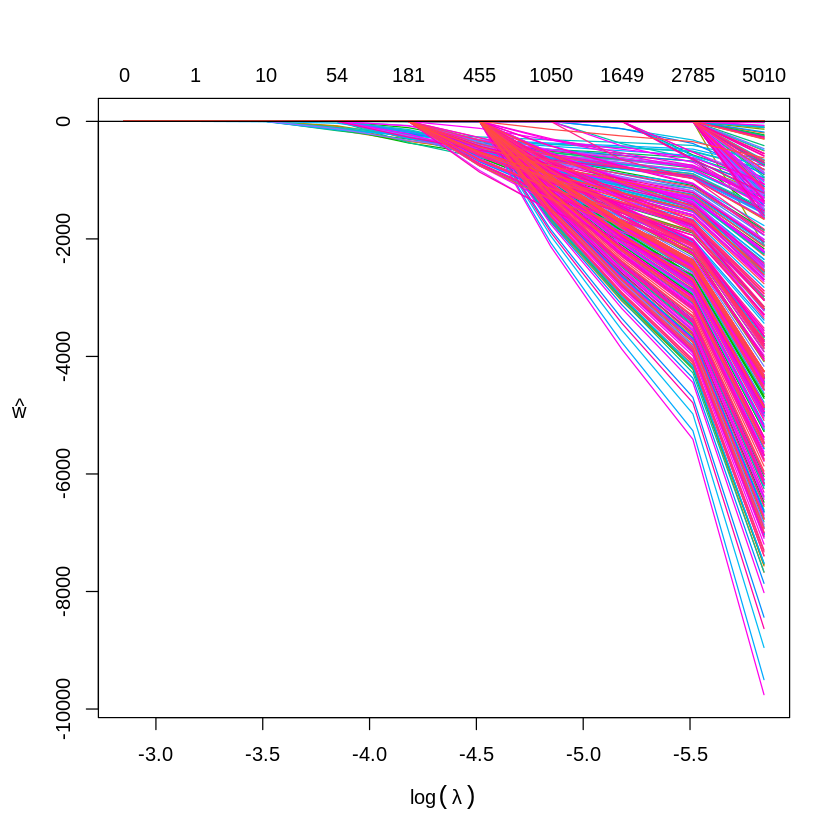

In [ ]:
plot(lasso.svm,xvar="norm") #square hinge loss instead of hinge loss
plot(lasso.svm,xvar="lambda")

In conclusion we can say that a Sparse SVM model is not suitable given our task and our limited computational resources.